In [1]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps, backtest
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam, LocScaleReparam
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features

from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

plt.style.use("seaborn")
pyro.enable_validation(True)
pyro.set_rng_seed(20200305)

Exampleにもある公共交通機関の利用者データを一時間毎に取得したものです。 一ヶ月分のデータ（24 hour × 30 days）

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


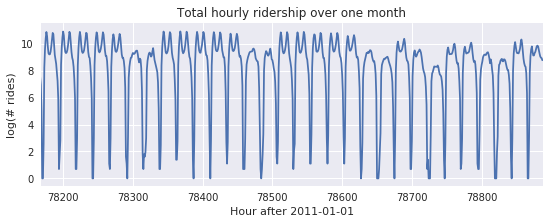

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

data = dataset["counts"].sum([-1, -2]).unsqueeze(-1).log1p()
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total hourly ridership over one month")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(len(data) - 24 * 30, len(data));

ひとまず訓練データとテストデータを分離しておき、 訓練データの一週間ごとの平均的推移を確認

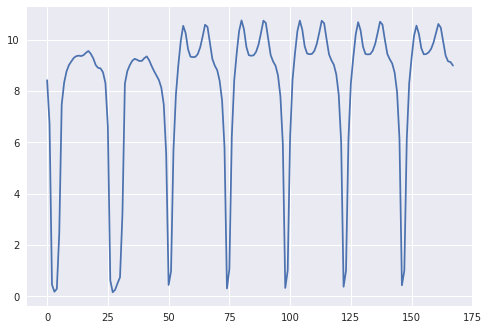

In [3]:
T0 = 0                # beginning
T2 = data.size(-2)    # end
T1 = T2 - 24 * 7 * 2  # train/test split
means = data[:T1 // (24 * 7) * 24 * 7].reshape(-1, 24 * 7).mean(0)
plt.plot(means)

#### 時系列モデル

In [4]:
class Model(ForecastingModel):

    ## 観測モデルの分布を書く。GaussianHMMに必要なパラメタに事前分布を準備。
    ## ノイズは周期的に変化することを織り込む
    def get_dist(self, duration):
        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)
        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)
        obs_matrix = torch.tensor([[1.]])

        with pyro.plate("hour_of_week", 24 * 7, dim=-1):
            obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_scale = periodic_repeat(obs_scale, duration, dim=-1)

        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)
        noise_dist = dist.GaussianHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        return noise_dist

    ## zero_data のshapeの後ろから2番目がdurationという決まりである。
    ## prediction は一週間ごとの平均を使う。
    ## HMMをnoise_distに利用しているので covariates は使われない。
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)
        noise_dist = self.get_dist(duration)
        self.predict(noise_dist, prediction)

GHMMの事前分布から100時間の系列データをサンプリング

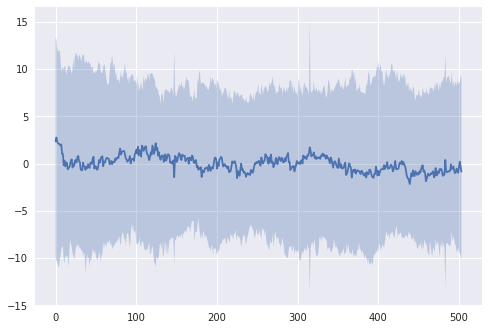

In [5]:
model = Model()
prior_sample = model.get_dist(T2-T1+24*7)([100])
p10, p50, p90 = quantile(prior_sample, (0.1, 0.5, 0.9)).squeeze(-1)

plt.plot(torch.arange(T2-T1+24*7), p50)
plt.fill_between(torch.arange(T2-T1+24*7), p10, p90, alpha=0.3)

学習

In [6]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(model, data[:T1], covariates[:T1], learning_rate=0.1, num_steps=1000)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 0.954787
INFO 	 step  100 loss = -0.0352517
INFO 	 step  200 loss = -0.0371375
INFO 	 step  300 loss = -0.0370885
INFO 	 step  400 loss = -0.0373036
INFO 	 step  500 loss = -0.0374779
INFO 	 step  600 loss = -0.0374321
INFO 	 step  700 loss = -0.0375629
INFO 	 step  800 loss = -0.037713
INFO 	 step  900 loss = -0.0377183


timescale = 59.37
trans_scale = 0.1074
CPU times: user 5min 27s, sys: 2.33 s, total: 5min 29s
Wall time: 3min


検証（バックテスト）

In [7]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
windows1 = backtest(data, covariates, Model,
                    min_train_window=20000, test_window=10000, stride=5000,
                    forecaster_options={"learning_rate": 0.1, "log_every": 1000,
                                        "warm_start": True})

INFO 	 Training on window [0:20000], testing on window [20000:30000]
INFO 	 step    0 loss = 0.994833
INFO 	 step 1000 loss = -0.00335869
INFO 	 Training on window [0:25000], testing on window [25000:35000]
INFO 	 step    0 loss = 0.141728
INFO 	 step 1000 loss = 0.0934926
INFO 	 Training on window [0:30000], testing on window [30000:40000]
INFO 	 step    0 loss = 0.101043
INFO 	 step 1000 loss = 0.0781365
INFO 	 Training on window [0:35000], testing on window [35000:45000]
INFO 	 step    0 loss = 0.0590834
INFO 	 step 1000 loss = 0.0529724
INFO 	 Training on window [0:40000], testing on window [40000:50000]
INFO 	 step    0 loss = 0.0263621
INFO 	 step 1000 loss = 0.022501
INFO 	 Training on window [0:45000], testing on window [45000:55000]
INFO 	 step    0 loss = 0.0111771
INFO 	 step 1000 loss = 0.00669155
INFO 	 Training on window [0:50000], testing on window [50000:60000]
INFO 	 step    0 loss = -0.0192642
INFO 	 step 1000 loss = -0.0208369
INFO 	 Training on window [0:55000], tes

CPU times: user 30min 27s, sys: 12.3 s, total: 30min 39s
Wall time: 17min 25s


予測

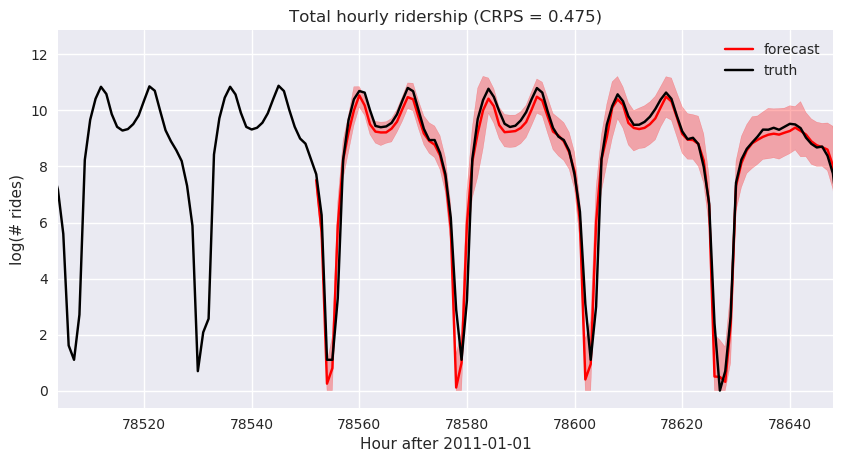

In [8]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(10, 5), dpi=100)
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 2, T1 + 24 * 4)
plt.legend(loc="best");